### 中阶API示范
- 中阶API主要包括各种模型层，损失函数，优化器，数据管道，特征列等等。

In [1]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)

    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))

    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)

2023-08-18 17:19:00.698946: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 17:19:00.756451: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 17:19:00.757098: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 17:19:01.832635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1. 线性回归模型

- 1.1 准备数据

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
from tensorflow.keras import layers,losses,metrics,optimizers
#样本数量
n = 400

# 生成测试用数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动

2023-08-18 17:20:06.593844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-18 17:20:06.626922: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


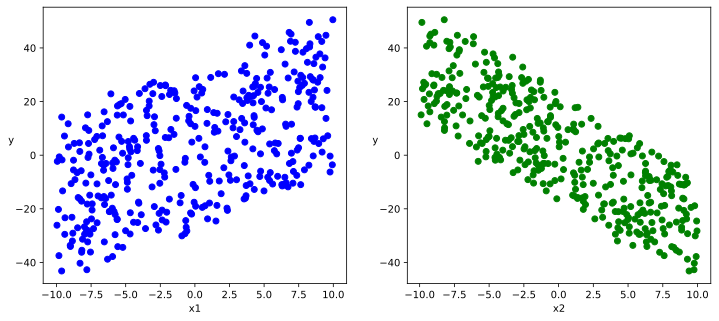

In [3]:
# 数据可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

In [4]:
#构建输入数据管道
ds = tf.data.Dataset.from_tensor_slices((X,Y)) \
     .shuffle(buffer_size = 100).batch(10) \
     .prefetch(tf.data.experimental.AUTOTUNE)  

- 1.2 定义模型

In [5]:
model = layers.Dense(units = 1) 
model.build(input_shape = (2,)) #用build方法创建variables
model.loss_func = losses.mean_squared_error
model.optimizer = optimizers.SGD(learning_rate=0.001)

- 1.3 训练模型

In [6]:
#使用autograph机制转换成静态图加速

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    grads = tape.gradient(loss,model.variables)
    model.optimizer.apply_gradients(zip(grads,model.variables))
    return loss

# 测试train_step效果
features,labels = next(ds.as_numpy_iterator())
train_step(model,features,labels)

<tf.Tensor: shape=(), dtype=float32, numpy=395.38593>

In [7]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        loss = tf.constant(0.0)
        for features, labels in ds:
            loss = train_step(model,features,labels)
        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",model.variables[0])
            tf.print("b =",model.variables[1])
train_model(model,epochs = 200)

================================================================================17:21:18
epoch = 50 loss =  3.7573905
w = [[1.99065602]
 [-2.97545266]]
b = [3.00998306]
================================================================================17:21:20
epoch = 100 loss =  3.86670446
w = [[2.00020027]
 [-2.98883605]]
b = [3.06222677]
================================================================================17:21:22
epoch = 150 loss =  2.50898576
w = [[1.98310173]
 [-2.97636271]]
b = [3.06224656]
================================================================================17:21:24
epoch = 200 loss =  4.27752972
w = [[2.00205493]
 [-2.99667978]]
b = [3.06378794]


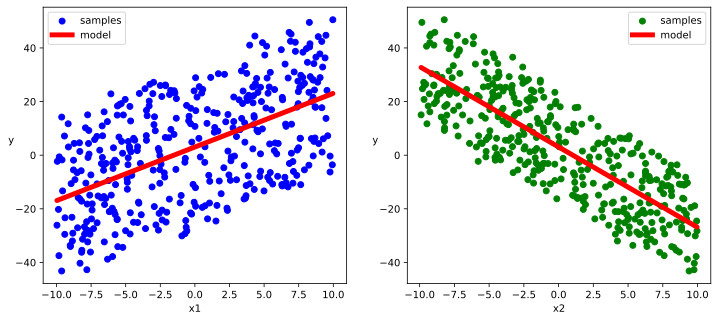

In [8]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.variables

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)



ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

2. DNN二分类模型
- 2.1 准备数据

In [9]:
from tensorflow.keras import layers,losses,metrics,optimizers

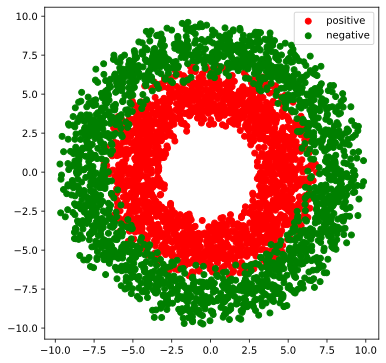

In [10]:
#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

#汇总样本
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);

In [11]:
#构建输入数据管道
ds = tf.data.Dataset.from_tensor_slices((X,Y)) \
     .shuffle(buffer_size = 4000).batch(100) \
     .prefetch(tf.data.experimental.AUTOTUNE) 

- 2.2 定义模型

In [12]:
class DNNModel(tf.Module):
    def __init__(self,name = None):
        super(DNNModel, self).__init__(name=name)
        self.dense1 = layers.Dense(4,activation = "relu") 
        self.dense2 = layers.Dense(8,activation = "relu")
        self.dense3 = layers.Dense(1,activation = "sigmoid")


    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def __call__(self,x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y

model = DNNModel()
model.loss_func = losses.binary_crossentropy
model.metric_func = metrics.binary_accuracy
model.optimizer = optimizers.Adam(learning_rate=0.001)

In [13]:
# 测试模型结构
(features,labels) = next(ds.as_numpy_iterator())

predictions = model(features)

loss = model.loss_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))
metric = model.metric_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))

tf.print("init loss:",loss)
tf.print("init metric",metric)

init loss: 1.39902043
init metric 0.54


- 2.3 训练模型

In [15]:
#使用autograph机制转换成静态图加速

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    grads = tape.gradient(loss,model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads,model.trainable_variables))

    metric = model.metric_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))

    return loss,metric

# 测试train_step效果
features,labels = next(ds.as_numpy_iterator())
train_step(model,features,labels)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.5098091>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.49>)

In [16]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        loss, metric = tf.constant(0.0),tf.constant(0.0)
        for features, labels in ds:
            loss,metric = train_step(model,features,labels)
        if epoch%10==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ",metric)
train_model(model,epochs = 60)

================================================================================17:23:24
epoch = 10 loss =  0.663515627 accuracy =  0.49
================================================================================17:23:24
epoch = 20 loss =  0.492216408 accuracy =  0.85
================================================================================17:23:25
epoch = 30 loss =  0.310940862 accuracy =  0.89
================================================================================17:23:26
epoch = 40 loss =  0.263080806 accuracy =  0.88
================================================================================17:23:26
epoch = 50 loss =  0.270491779 accuracy =  0.88
================================================================================17:23:27
epoch = 60 loss =  0.148748651 accuracy =  0.94


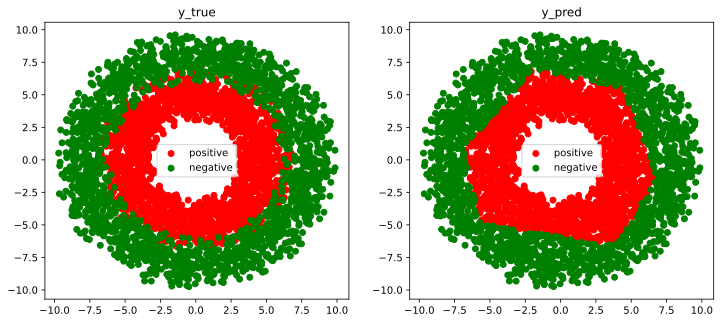

In [17]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
ax1.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0].numpy(),Xp_pred[:,1].numpy(),c = "r")
ax2.scatter(Xn_pred[:,0].numpy(),Xn_pred[:,1].numpy(),c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");